# Data Science Technical Execution for Predicting Severe COVID-19 Cases



In [ ]:
# The necessary files are obtained from Drive so that the code works well and not having to import them every time their use is required
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data files from drive, if not you can comment this part of the code and add the files manually to the folder of colab
hospital1 = '/content/drive/MyDrive/Data Processes/hospital1.xlsx'
hospital2 = '/content/drive/MyDrive/Data Processes/hospital2.xlsx'

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, StandardScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, RFE, SequentialFeatureSelector
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
import numpy as np
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import statistics as stat
import math
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
# Read the Excel files
df1 = pd.read_excel(hospital1)
df2 = pd.read_excel(hospital2)

# Combine the files into one
df = pd.concat([df1, df2], ignore_index=True)

# Save the result file combination of both datasets
df.to_excel('hospital.xlsx', index=False)

# 1. Preprocess
In this section the preprocess of the combined dataset of both hospital data of COVID 19 is going to take place.

In [ ]:
# Display basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27449 entries, 0 to 27448
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   patient ID                       14712 non-null  float64       
 1   patient ID.1                     14712 non-null  float64       
 2   nationality                      14712 non-null  object        
 3   age                              27446 non-null  float64       
 4   gender K=female E=male           14712 non-null  object        
 5   date_of_first_symptoms           27446 non-null  datetime64[ns]
 6   BASVURUTARIHI                    14712 non-null  datetime64[ns]
 7   fever_temperature                25759 non-null  float64       
 8   oxygen_saturation                27438 non-null  float64       
 9   history_of_fever                 27441 non-null  float64       
 10  cough                            27448 non-null  float64  

In [ ]:
# Display basic information
print(df.head())

   patient ID  patient ID.1 nationality   age gender K=female E=male  \
0  11850006.0    11850006.0        T.C.  47.0                      K   
1   4373630.0     4373630.0        T.C.  23.0                      K   
2  12172023.0    12172023.0        T.C.  26.0                      K   
3  72856168.0    72856168.0        T.C.  60.0                      K   
4  72200559.0    72200559.0        T.C.  72.0                      K   

  date_of_first_symptoms BASVURUTARIHI  fever_temperature  oxygen_saturation  \
0             2022-01-01    2022-01-01               38.2               96.0   
1             2022-01-01    2022-01-01               37.0               96.0   
2             2022-01-01    2022-01-01               38.0               95.0   
3             2022-01-01    2022-01-01               36.5               95.0   
4             2021-12-22    2021-12-22               36.9               96.0   

   history_of_fever  ...  dementia  tuberculosis  smoking  other_risks  \
0           

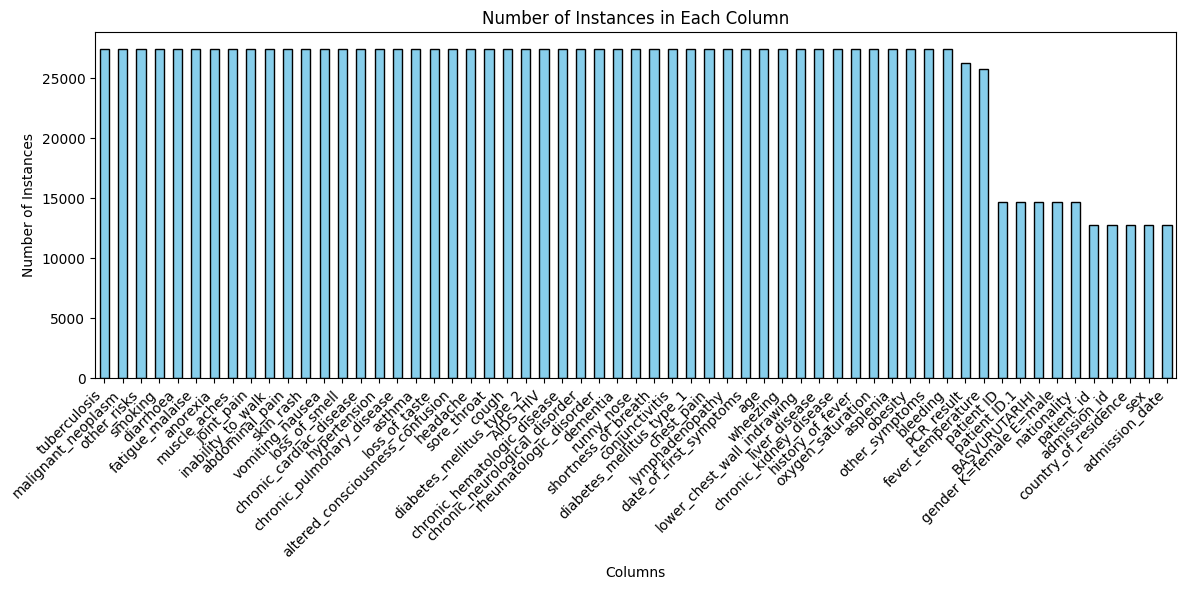

In [ ]:
# Graph with the number of instances per column
non_missing_counts = df.count()

# Plot the counts as a bar chart
plt.figure(figsize=(12, 6))
non_missing_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Instances in Each Column")
plt.xlabel("Columns")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Data integration from different sources and Treatment of duplicates
Patient ID column is repeated in the dataset, so patien ID.1 is removed. Also, the combination of patient ID from both datasets is done in order to have just one column with this information.

In [ ]:
# Merge 'patient ID' and 'patient_id' into a single column
df['patient ID'] = df['patient ID'].combine_first(df['patient_id'])

# Drop 'patient_id' and 'patient ID.1'
df.drop(columns=['patient_id', 'patient ID.1'], inplace=True)

Nationality and country_of_residence are merged as they are referred to the same thing but in the two different datasets, they are combined into nationality.

In [ ]:
# Merge 'nationality' and 'country_of_residence' into a single column
df['nationality'] = df['nationality'].combine_first(df['country_of_residence'])

# Drop 'country_of_residence'
df.drop(columns=['country_of_residence'], inplace=True)

The mapping of the gender codes is done in order to change the K for female and E for male in the 2 different columns referred to the gender. Then , this two columns are combined in to one, and this column is renamed to 'gender'.

In [ ]:
# Map gender codes
df['gender K=female E=male'] = df['gender K=female E=male'].map({'K': 'female', 'E': 'male'})

# Map gender codes
df['sex'] = df['sex'].map({'K': 'female', 'E': 'male'})

# Combine both columns
df['gender K=female E=male'] = df['gender K=female E=male'].combine_first(df['sex'])

# Drop 'sexe'
df.drop(columns=['sex'], inplace=True)

# Rename a single column
df.rename(columns={'gender K=female E=male': 'gender'}, inplace=True)

The 'admission_id', 'admission_date' and 'BASVURUTARIHI' columns are removed as they can only be found in the second dataset and they contain only half of the rows of the whole combined dataset

In [ ]:
# Drop 'admission_id', 'admission_date' and 'BASVURUTARIHI'
df.drop(columns=['admission_id', 'admission_date', 'BASVURUTARIHI'], inplace=True)

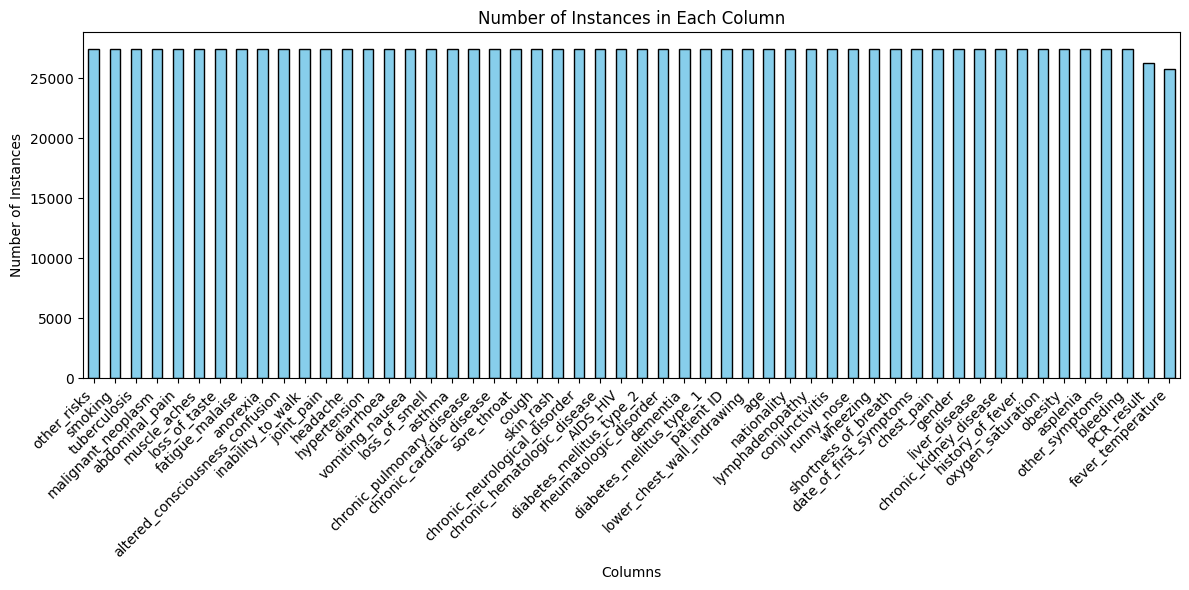

In [ ]:
# Graph with the number of instances per column
non_missing_counts = df.count()

# Plot the counts as a bar chart
plt.figure(figsize=(12, 6))
non_missing_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Instances in Each Column")
plt.xlabel("Columns")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Missing values
Missing values are checked in order to fill then using the mean for the numerical columns and the mode for categorical ones. The unique date type column is filled with a default value as simpple imputer does not performs on this kind of columns.

In [ ]:
# Checking missing values for the dataset
missing_values = df.isnull().sum()
print(missing_values)

patient ID                            3
nationality                           3
age                                   3
gender                                4
date_of_first_symptoms                3
fever_temperature                  1690
oxygen_saturation                    11
history_of_fever                      8
cough                                 1
sore_throat                           1
runny_nose                            3
wheezing                              3
shortness_of_breath                   3
lower_chest_wall_indrawing            3
chest_pain                            3
conjunctivitis                        3
lymphadenopathy                       3
headache                              1
loss_of_smell                         1
loss_of_taste                         1
fatigue_malaise                       1
anorexia                              1
altered_consciousness_confusion       1
muscle_aches                          1
joint_pain                            1


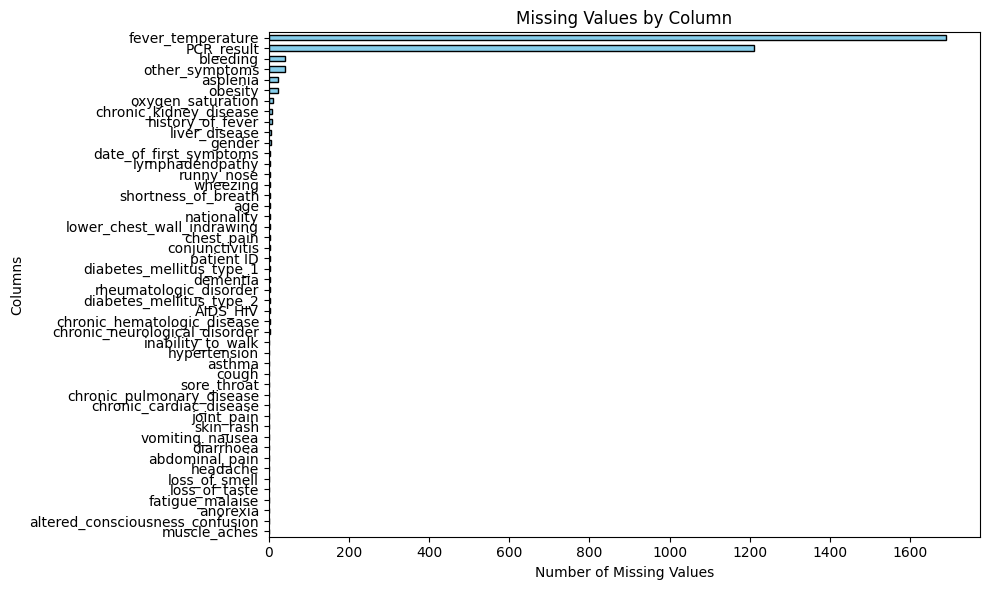

In [ ]:
# Count missing values per column
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_values = missing_values[missing_values > 0]

# Plot bar chart
plt.figure(figsize=(10, 6))
missing_values.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Missing Values by Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

In [ ]:
# Separate columns into categorical and numerical
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values in numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Impute missing values in categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Check if there are any remaining missing values
missing_values_after_imputation = df.isnull().sum()
print(missing_values_after_imputation)

patient ID                         0
nationality                        0
age                                0
gender                             0
date_of_first_symptoms             3
fever_temperature                  0
oxygen_saturation                  0
history_of_fever                   0
cough                              0
sore_throat                        0
runny_nose                         0
wheezing                           0
shortness_of_breath                0
lower_chest_wall_indrawing         0
chest_pain                         0
conjunctivitis                     0
lymphadenopathy                    0
headache                           0
loss_of_smell                      0
loss_of_taste                      0
fatigue_malaise                    0
anorexia                           0
altered_consciousness_confusion    0
muscle_aches                       0
joint_pain                         0
inability_to_walk                  0
abdominal_pain                     0
d

In [ ]:
# Impute missing values with a default date, because simpleimputer gives problems when dealing with dates
df['date_of_first_symptoms'] = df['date_of_first_symptoms'].fillna(pd.to_datetime('2022-01-01'))

In [ ]:
# Check if there are still missing values in the date_of_first_symptoms column
missing_dates = df['date_of_first_symptoms'].isnull().sum()
print(f"Missing values in the date column: {missing_dates}")

Missing values in the date column: 0


### Transformation into numerical variables
Categorical columns are searched in order to transform them using label encoder for the ones with only 2 different values, and one-hot encoding for the ones with more than 2 different values.
The transformation of non-numerical variables into numerical format is important for machine learning algorithms to interpret, process, and learn patterns in the data, as it ensures compatibility with algorithms.

In [ ]:
#Identify categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Check unique values for each categorical column
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Number of unique values: {len(unique_values)}\n")

Column: nationality
Number of unique values: 111

Column: gender
Number of unique values: 2

Column: PCR_result
Number of unique values: 2



In [ ]:
# Apply transformations to categorical columns
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_values = df[col].unique()

    if len(unique_values) == 2:
        # Apply Label Encoding (for binary categorical variables)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        # Apply One-Hot Encoding (for multi-class categorical variables)
        df = pd.get_dummies(df, columns=[col], drop_first=True)  # drop_first=True to avoid multicollinearity

In [ ]:
# View the transformed DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27449 entries, 0 to 27448
Columns: 161 entries, patient ID to nationality_Zimbabwe
dtypes: bool(110), datetime64[ns](1), float64(48), int64(2)
memory usage: 13.6 MB
None


In [ ]:
# View the column names
print(df.columns[:60])

Index(['patient ID', 'age', 'gender', 'date_of_first_symptoms',
       'fever_temperature', 'oxygen_saturation', 'history_of_fever', 'cough',
       'sore_throat', 'runny_nose', 'wheezing', 'shortness_of_breath',
       'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
       'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
       'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
       'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain',
       'diarrhoea', 'vomiting_nausea', 'skin_rash', 'bleeding',
       'other_symptoms', 'chronic_cardiac_disease', 'hypertension',
       'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease',
       'obesity', 'liver_disease', 'asplenia', 'chronic_neurological_disorder',
       'malignant_neoplasm', 'chronic_hematologic_disease', 'AIDS_HIV',
       'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
       'rheumatologic_disorder', 'dementia', 'tuberculosis', 'smoking',
      

In [ ]:
# View the first few rows to check the label encoder and one-hot encoded columns
print(df[['gender', 'PCR_result', 'nationality_Turkmenistan', 'nationality_USA']].head())

   gender  PCR_result  nationality_Turkmenistan  nationality_USA
0       0           1                     False            False
1       0           1                     False            False
2       0           1                     False            False
3       0           1                     False            False
4       0           1                     False            False


### Target variable relocation
The target variable or class is moved to the end of the dataset.

In [ ]:
# Move 'PCR_result' to the end as it is the target variable
cols = [col for col in df if col != 'PCR_result']  # Get all columns except 'PCR_result'
df = df[cols + ['PCR_result']]  # Append 'PCR_result' to the end

## Output dataset for use in Modeling
df.to_csv('cleaned.csv',index=False)

# Check the result
print(df.columns[-10:])  # Print the last 10 columns to verify

Index(['nationality_USA', 'nationality_Ukraine',
       'nationality_United Arab Emirates',
       'nationality_United Kingdom (Great Britain)', 'nationality_Uzbekistan',
       'nationality_Venezuela', 'nationality_Yemen', 'nationality_Zambia',
       'nationality_Zimbabwe', 'PCR_result'],
      dtype='object')


### Feature Selection
Feature selection is performed to find the best input variables inside the dataset using select percentile with a 40% and mutual information as suggested in the theory provided in moodle. The date column is transformed into numeric type, in order for it to be eligible for the feature selection.


In [ ]:
# Convert 'date_of_first_symptoms' to numeric: number of days from the minimum date
df['date_of_first_symptoms'] = (df['date_of_first_symptoms'] - df['date_of_first_symptoms'].min()).dt.days

# Separate features and target
X = df.drop(columns=['PCR_result'])
y = df['PCR_result']

# Select the top 40% of features based on mutual information
selector = SelectPercentile(mutual_info_classif, percentile=40)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names (based on the boolean mask of selected features)
selected_features = X.columns[selector.get_support()]

# Print the selected features
print("Selected Features:", selected_features)

# Print the number of selected features
print("Number of Selected Features:", len(selected_features))

# Get X but only with the selected features as columns
X_feature_selection = X[selected_features]

Selected Features: Index(['patient ID', 'gender', 'date_of_first_symptoms', 'fever_temperature',
       'history_of_fever', 'shortness_of_breath', 'chest_pain',
       'fatigue_malaise', 'altered_consciousness_confusion', 'muscle_aches',
       'joint_pain', 'abdominal_pain', 'diarrhoea', 'skin_rash', 'bleeding',
       'other_symptoms', 'chronic_pulmonary_disease', 'liver_disease',
       'chronic_neurological_disorder', 'AIDS_HIV', 'diabetes_mellitus_type_2',
       'rheumatologic_disorder', 'dementia', 'nationality_American Samoa',
       'nationality_Argentina', 'nationality_Armenia', 'nationality_Belgium',
       'nationality_Bosnia And HerzegovÄ±na', 'nationality_Botswana',
       'nationality_Brazil', 'nationality_British Indian Ocean Territory',
       'nationality_Bulgaria', 'nationality_Congo',
       'nationality_CÃ”TE DIVOIRE (Ivory Coast)',
       'nationality_Democratic Republic Of The Congo', 'nationality_Egypt',
       'nationality_Estonia', 'nationality_Ethiopia', 'nat

### Feature discretization
Numerical features are discretized using the KBinsDiscretizer with 5 bins. This transformation is done  as it makes the data easier to interpret and more suitable for certain models.

In [ ]:
# Specify the features to discretize, only numerical ones will be used
numerical_features = X_feature_selection.select_dtypes(include=['float64', 'int64']).columns

# Initialize the KBinsDiscretizer
# n_bins is the number of bins you want to divide your data into
# encode='ordinal' means the bins will be labeled with integers (0, 1, 2,...)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Apply the discretizer to the selected numerical features
X_feature_selection[numerical_features] = discretizer.fit_transform(X_feature_selection[numerical_features])

# View the discretized features
print(X_feature_selection[numerical_features].head())

   patient ID  gender  date_of_first_symptoms  fever_temperature  \
0         0.0     0.0                     4.0                3.0   
1         0.0     0.0                     4.0                2.0   
2         0.0     0.0                     4.0                3.0   
3         3.0     0.0                     4.0                1.0   
4         3.0     0.0                     3.0                1.0   

   history_of_fever  shortness_of_breath  chest_pain  fatigue_malaise  \
0               0.0                  0.0         0.0              0.0   
1               4.0                  0.0         0.0              0.0   
2               4.0                  0.0         0.0              0.0   
3               0.0                  0.0         0.0              0.0   
4               0.0                  0.0         4.0              0.0   

   altered_consciousness_confusion  muscle_aches  ...  skin_rash  bleeding  \
0                              0.0           0.0  ...        0.0       0.0

<ipython-input-119-9d47603da1df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feature_selection[numerical_features] = discretizer.fit_transform(X_feature_selection[numerical_features])


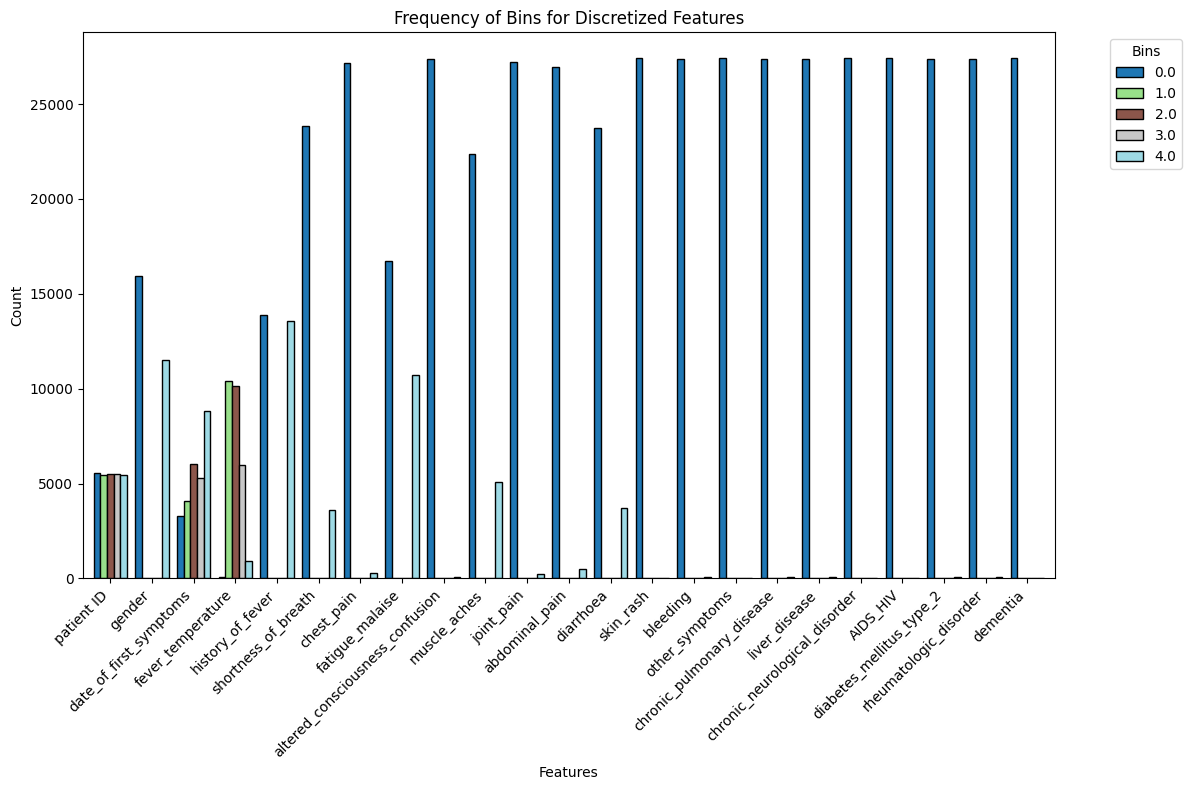

In [ ]:
bin_counts = pd.DataFrame()

for feature in numerical_features:
    # Count the frequency of each bin/category
    value_counts = X_feature_selection[feature].value_counts().sort_index()
    bin_counts[feature] = value_counts

# Transpose the DataFrame for plotting
bin_counts = bin_counts.fillna(0).T

# Plot the grouped bar chart
bin_counts.plot(kind='bar', figsize=(12, 8), width=0.8, colormap='tab20', edgecolor='black')
plt.title("Frequency of Bins for Discretized Features")
plt.xlabel("Features")
plt.ylabel("Count")
plt.legend(title="Bins", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Feature scaling
Numerical features are standarized using the StandardScaler method, in order to have the features in the same range ensuring that all input variables contribute equally to the model

In [ ]:
# Separate the numerical and non-numerical columns
numerical_columns = X_feature_selection.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = X_feature_selection.select_dtypes(exclude=['float64', 'int64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to only the numerical columns
X_feature_selection_scaled = X_feature_selection.copy()  # Make a copy to avoid modifying the original
X_feature_selection_scaled[numerical_columns] = scaler.fit_transform(X_feature_selection[numerical_columns])

# The non-numerical columns are preserved as they are
# View the scaled features
print(X_feature_selection_scaled.head())

   patient ID    gender  date_of_first_symptoms  fever_temperature  \
0   -1.410104 -0.849082                1.124934           1.289386   
1   -1.410104 -0.849082                1.124934           0.115627   
2   -1.410104 -0.849082                1.124934           1.289386   
3    0.711079 -0.849082                1.124934          -1.058132   
4    0.711079 -0.849082                0.399410          -1.058132   

   history_of_fever  shortness_of_breath  chest_pain  fatigue_malaise  \
0         -0.988589            -0.388647   -0.098734        -0.801755   
1          1.011837            -0.388647   -0.098734        -0.801755   
2          1.011837            -0.388647   -0.098734        -0.801755   
3         -0.988589            -0.388647   -0.098734        -0.801755   
4         -0.988589            -0.388647   10.128234        -0.801755   

   altered_consciousness_confusion  muscle_aches  ...  nationality_Sudan  \
0                        -0.043145     -0.476205  ...           

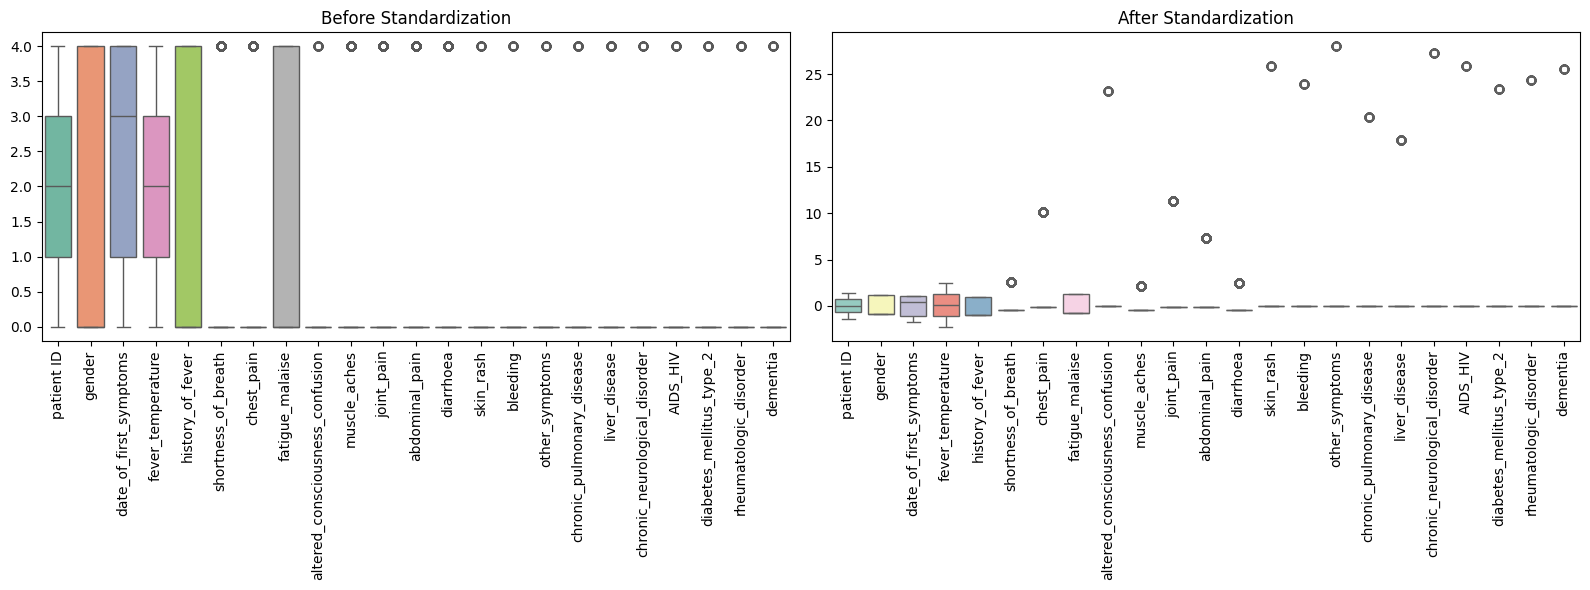

In [ ]:
# Box plot before and after standardization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # Increased figure size

# Box plot before standardization
sns.boxplot(data=X_feature_selection[numerical_columns], ax=axes[0], palette="Set2")
axes[0].set_title("Before Standardization")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels to 90 degrees

# Box plot after standardization
sns.boxplot(data=X_feature_selection_scaled[numerical_columns], ax=axes[1], palette="Set3")
axes[1].set_title("After Standardization")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels to 90 degrees

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

  ### Treatment of imbalanced data
  It is checked if the class is imbalanced, to ensure that machine learning models do not favor the majority class, leading to biased predictions. In this case it is imbalanced, so SMOTE is used to apply oversampling on the minority class in order to obtain the same amount of instances in both classes

In [ ]:
# Check class distribution in y, the target feature
print(y.value_counts())

PCR_result
1    23422
0     4027
Name: count, dtype: int64


In [ ]:
# Calculate imbalance ratio
majority_class = y.value_counts().max()
minority_class = y.value_counts().min()
imbalance_ratio = majority_class / minority_class

print("Imbalance Ratio:", imbalance_ratio)

Imbalance Ratio: 5.816240377452198


<ipython-input-125-ee1ce42a8519>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


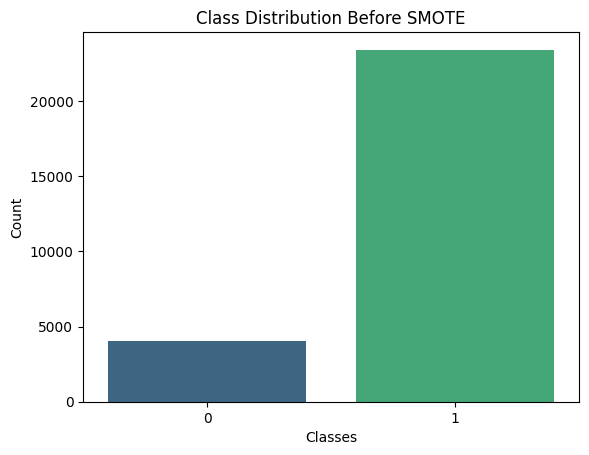

In [ ]:
# Bar chart for class distribution
sns.countplot(x=y, palette='viridis')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_feature_selection_scaled, y)

# Check the new class distribution
print(y_resampled.value_counts())

PCR_result
1    23422
0    23422
Name: count, dtype: int64


<ipython-input-127-e3d81ab25205>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='viridis')


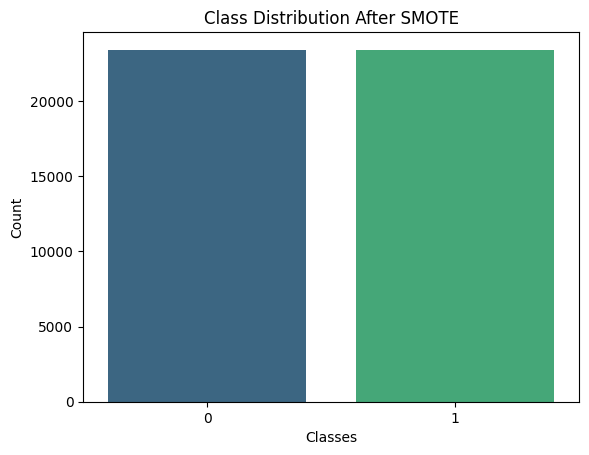

In [ ]:
# Bar plot after SMOTE (resampled distribution)
sns.countplot(x=y_resampled, palette='viridis')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

### Extracting the dataset into an 'xlsx' format file
The final data frame is converted to xlsx format, in order to have the data set available in xlsx format.

In [ ]:
# Combine X_feature_selection_scaled and y into a single DataFrame
final_df = pd.concat([X_resampled, y_resampled], axis=1)

# View the resulting DataFrame
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46844 entries, 0 to 46843
Data columns (total 65 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   patient ID                                                     46844 non-null  float64
 1   gender                                                         46844 non-null  float64
 2   date_of_first_symptoms                                         46844 non-null  float64
 3   fever_temperature                                              46844 non-null  float64
 4   history_of_fever                                               46844 non-null  float64
 5   shortness_of_breath                                            46844 non-null  float64
 6   chest_pain                                                     46844 non-null  float64
 7   fatigue_malaise                                           

In [ ]:
# Save the DataFrame to an Excel file
final_df.to_excel('hospital_final.xlsx', index=False)

print("File saved as 'hospital_final.xlsx'")

File saved as 'hospital_final.xlsx'


### Advanced outlier detection
It is checked if there are outliers in the numerical columns of the dataset and a pair plot is done for the columns with the most outliers

In [ ]:
# Extract numerical columns
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
X_numerical = final_df[numerical_columns]

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict outliers
outlier_labels = iso_forest.fit_predict(X_numerical)

# Add the outlier labels to the original dataframe
final_df['outlier'] = outlier_labels
final_df['outlier'] = final_df['outlier'].map({1: 'Normal', -1: 'Outlier'})

# Analyze results
print(final_df['outlier'].value_counts())  # Count of normal and outlier instances
print(final_df[final_df['outlier'] == 'Outlier'].head())  # View some detected outliers

outlier
Normal     44501
Outlier     2343
Name: count, dtype: int64
     patient ID    gender  date_of_first_symptoms  fever_temperature  \
36     0.711079 -0.849082                0.399410           1.289386   
58     1.418140 -0.849082                1.124934           1.289386   
80     1.418140 -0.849082                1.124934           2.463146   
90     0.004018  1.177742                1.124934          -1.058132   
123   -0.703043 -0.849082                1.124934          -1.058132   

     history_of_fever  shortness_of_breath  chest_pain  fatigue_malaise  \
36          -0.988589            -0.388647   -0.098734        -0.801755   
58           1.011837            -0.388647   -0.098734         1.247300   
80           1.011837             2.573031   10.128234        -0.801755   
90           1.011837             2.573031   10.128234        -0.801755   
123         -0.988589             2.573031   10.128234        -0.801755   

     altered_consciousness_confusion  muscle_ach

In [ ]:
# Get only rows marked as 'Outlier'
outliers_only = final_df[final_df['outlier'] == 'Outlier']

# Calculate the counts of outliers for each numerical column
outlier_count = (outliers_only[numerical_columns] != 0).sum()

# Sort columns by count
columns_with_more_outliers = outlier_count.sort_values(ascending=False).index[:3]  # Top 3 by count

print("Columns with the most outliers:", columns_with_more_outliers)

Columns with the most outliers: Index(['patient ID', 'gender', 'dementia'], dtype='object')


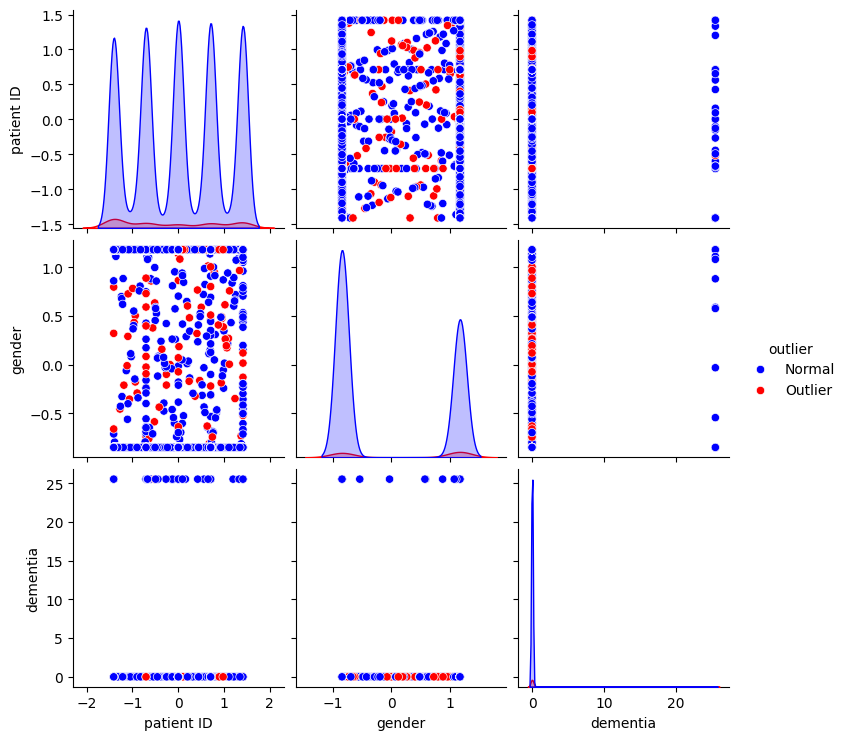

In [ ]:
# Pair plot for the selected columns
sns.pairplot(final_df, vars=columns_with_more_outliers, hue='outlier', diag_kind='kde', palette={'Normal': 'blue', 'Outlier': 'red'})

# 2. Exploratory Data Analysis
In this section data is explored in order to study possible relations prior to the implementation of the models




In [ ]:
data = final_df

# Print the summary of variables
print("Summary of Variables:")
print(f"Total rows: {data.shape[0]}")
print(f"Total columns: {data.shape[1]}")
print("\nVariable Names:")
for i, column in enumerate(data.columns):
    print(f"{i + 1}. {column}")

# Provide a brief statistical summary for numerical columns
print("\nStatistical Summary for Numerical Columns:")
print(data.describe())

Summary of Variables:
Total rows: 46844
Total columns: 66

Variable Names:
1. patient ID
2. gender
3. date_of_first_symptoms
4. fever_temperature
5. history_of_fever
6. shortness_of_breath
7. chest_pain
8. fatigue_malaise
9. altered_consciousness_confusion
10. muscle_aches
11. joint_pain
12. abdominal_pain
13. diarrhoea
14. skin_rash
15. bleeding
16. other_symptoms
17. chronic_pulmonary_disease
18. liver_disease
19. chronic_neurological_disorder
20. AIDS_HIV
21. diabetes_mellitus_type_2
22. rheumatologic_disorder
23. dementia
24. nationality_American Samoa
25. nationality_Argentina
26. nationality_Armenia
27. nationality_Belgium
28. nationality_Bosnia And HerzegovÄ±na
29. nationality_Botswana
30. nationality_Brazil
31. nationality_British Indian Ocean Territory
32. nationality_Bulgaria
33. nationality_Congo
34. nationality_CÃ”TE DIVOIRE (Ivory Coast)
35. nationality_Democratic Republic Of The Congo
36. nationality_Egypt
37. nationality_Estonia
38. nationality_Ethiopia
39. nationality_G

## Nationality analysis
In this section we observe where the data comes from in order to stablish if data from some country might not be useful. We show the proportion of each nationality excluding TC

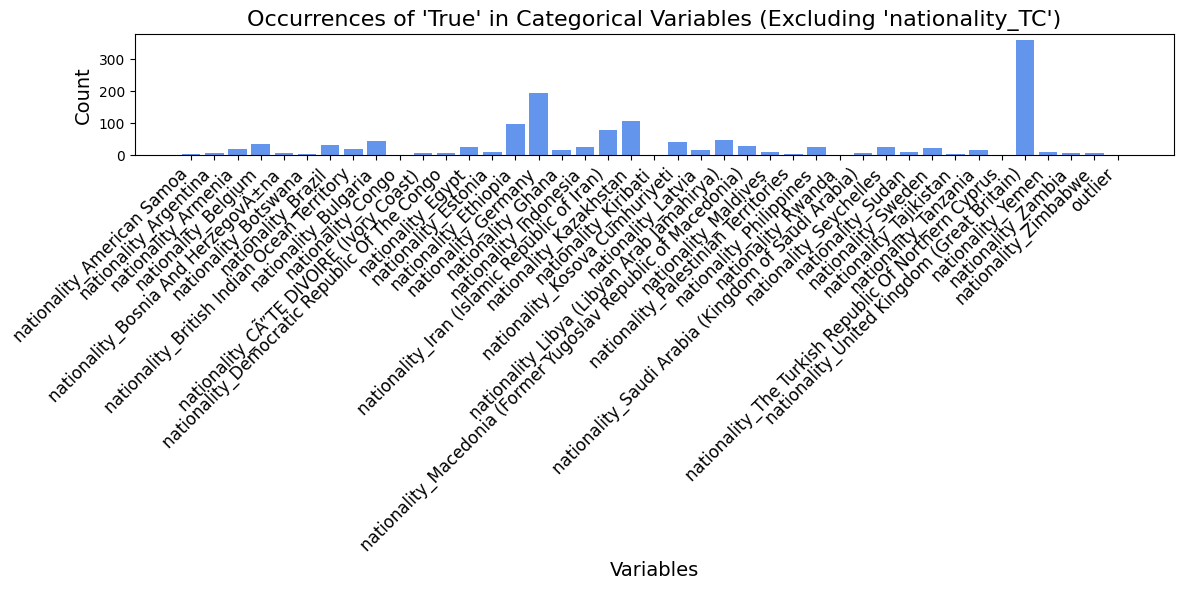

In [ ]:
# Select categorical columns excluding 'nationality_TC'
categorical_columns = data.select_dtypes(include=['object', 'bool']).columns
categorical_columns = [col for col in categorical_columns if col != 'nationality_T.C.']

# Count occurrences of True for each categorical column
true_counts = {}
for col in categorical_columns:
    true_counts[col] = data[col].apply(lambda x: str(x).lower() == 'true').sum()

# Plot the results as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(true_counts.keys(), true_counts.values(), color='cornflowerblue')
plt.title("Occurrences of 'True' in Categorical Variables (Excluding 'nationality_TC')", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Most of the nationalities has very few observations, while a few concentrate almost all

Make a factor of the nationalities instead of the boolean values

In [ ]:
# Select the columns with nationalities
nationality_columns = [col for col in data.columns if col.startswith("nationality_")]

# Create a new column with 'nationality' to verify which ones are True
data['nationality'] = data[nationality_columns].apply(
    lambda row: next((col.replace('nationality_', '') for col, val in row.items() if val), None),
    axis=1
)

# Create a new DataFrame without the nationality columns
data_without_nationalities = data.drop(columns=nationality_columns)

## Correlations
To study the correlation between variables, we plot a correlation plot, order the variables by the correlations and create a dendrogram

<Figure size 1500x1200 with 0 Axes>

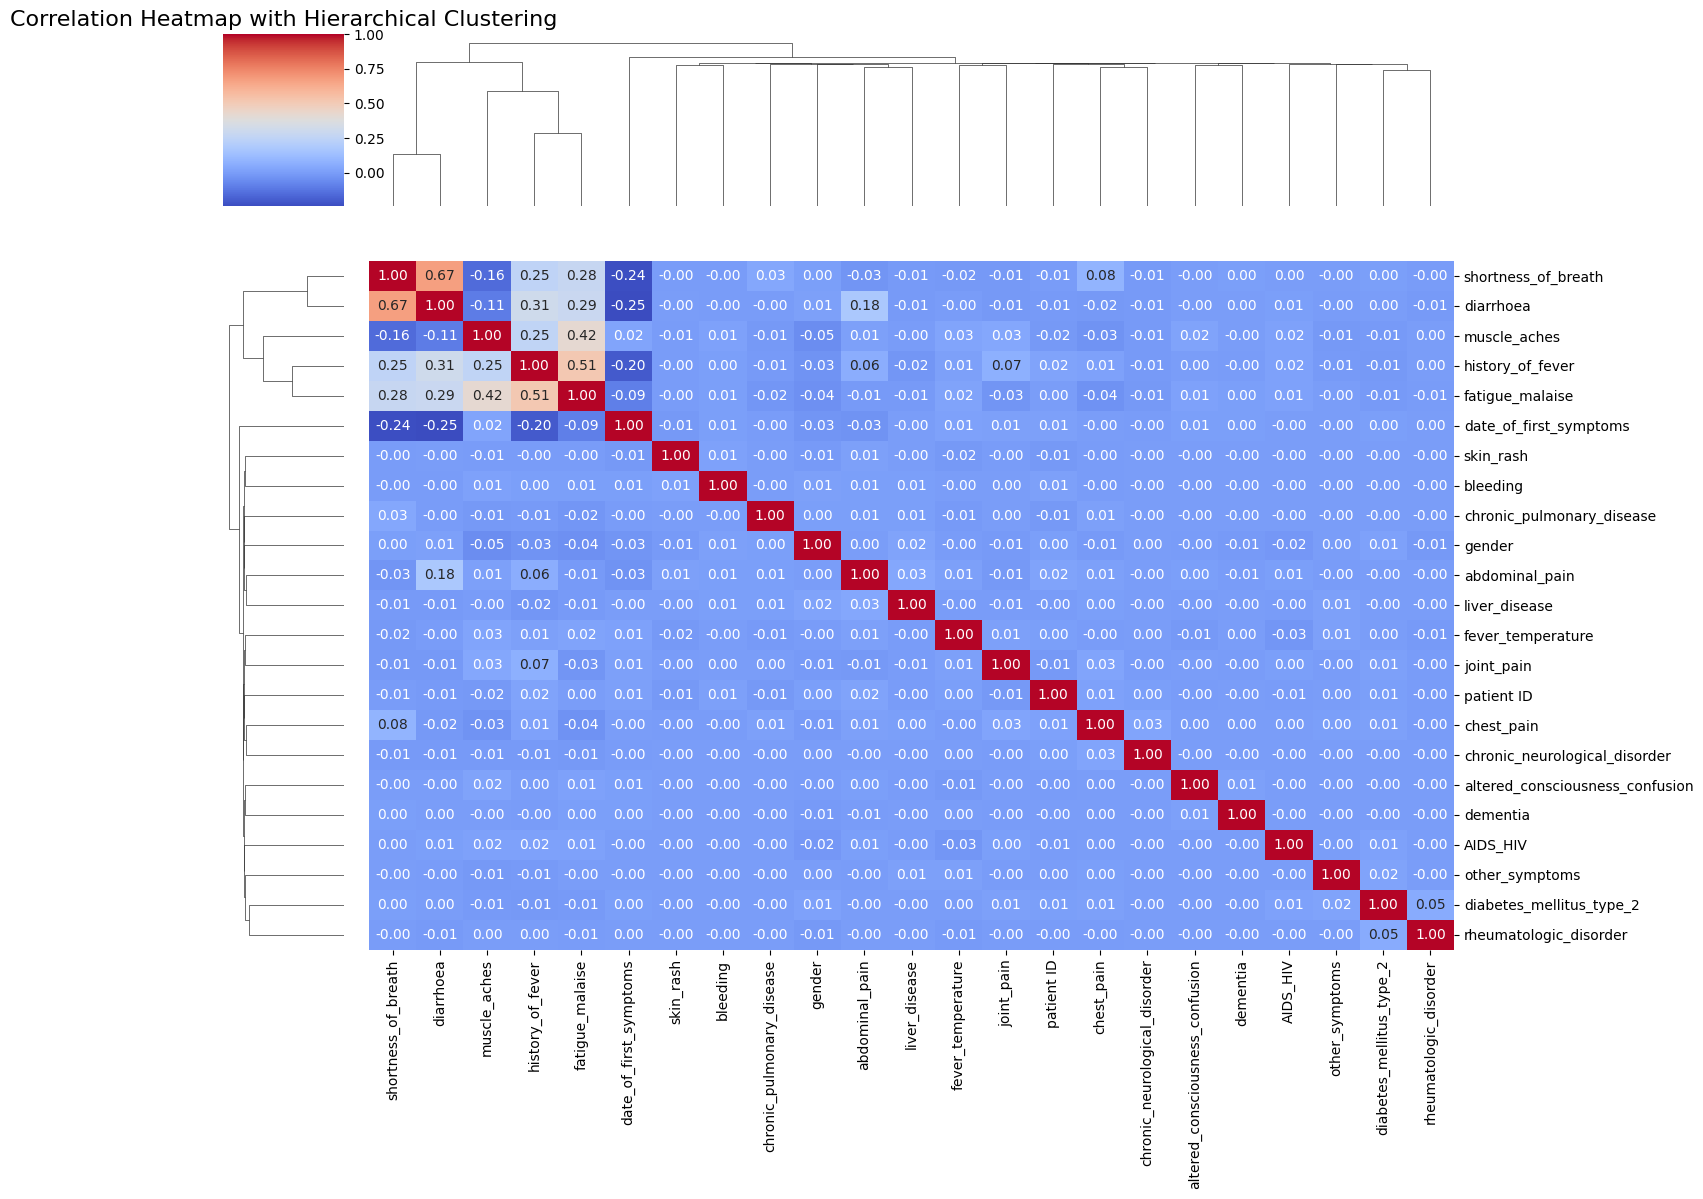

Chi-Square Test Results:
Chi-Square Statistic: 1105.9018354998348
P-Value: 7.899044012389863e-206
Degrees of Freedom: 40


<Figure size 1200x600 with 0 Axes>

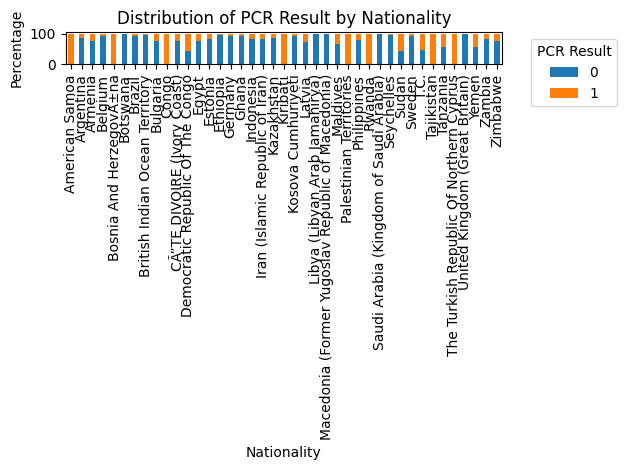

In [ ]:
# Correlation Analysis with Hierarchical Clustering
def correlation_clustering_analysis(data, target_column='PCR_result'):
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = [col for col in numeric_columns if col != target_column]
    numeric_data = data[numeric_columns]

    # Correlation Matrix
    correlation_matrix = numeric_data.corr()

    # Hierarchical Clustering
    distance_matrix = 1 - correlation_matrix.abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')

    # Clustering visualization with heatmap
    plt.figure(figsize=(15, 12))
    sns.clustermap(correlation_matrix,
                   cmap="coolwarm",
                   annot=True,
                   fmt=".2f",
                   figsize=(15, 12),
                   dendrogram_ratio=(.1, .2))
    plt.title("Correlation Heatmap with Hierarchical Clustering", fontsize=16)
    plt.tight_layout()
    plt.show()

    return correlation_matrix

# Chi-Square Analysis by Nationality
def chi_square_nationality_analysis(data, nationality_column='nationality', target_column='PCR_result'):
    # Contigency table
    contingency_table = pd.crosstab(data[nationality_column], data[target_column])

    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-Value: {p_value}")
    print(f"Degrees of Freedom: {dof}")

    # Distribution Visualization
    plt.figure(figsize=(12, 6))
    contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
    contingency_table_percentage.plot(kind='bar', stacked=True)
    plt.title('Distribution of PCR Result by Nationality')
    plt.xlabel('Nationality')
    plt.ylabel('Percentage')
    plt.legend(title='PCR Result', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return contingency_table, p_value

# Distribution of Numerical Variables by Country and Target
def numeric_distribution_by_nationality(data, nationality_column='nationality', target_column='PCR_result'):
    # Seleccionar variables numéricas
    numeric_columns = data.select_dtypes(include=['number']).columns
    numeric_columns = [col for col in numeric_columns if col not in [target_column]]

    n_columns = len(numeric_columns)
    fig, axes = plt.subplots(nrows=(n_columns + 1) // 2, ncols=2, figsize=(16, 4 * ((n_columns + 1) // 2)))
    axes = axes.ravel()

    # Boxplot for each numerical variable
    for i, column in enumerate(numeric_columns):
        sns.boxplot(x=nationality_column,
                    y=column,
                    hue=target_column,
                    data=data,
                    ax=axes[i])
        axes[i].set_title(f'{column} Distribution by Nationality and PCR Result')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    # Eliminate extra subplots is they are odd
    if n_columns % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

correlation_matrix = correlation_clustering_analysis(data)
contingency_table, p_value = chi_square_nationality_analysis(data)

Most variable associated with Covid Symptoms are correlated, so this might end in some problems of multicollinearity.


The test shows a big relation between nationality and PCR test. Based on the graph some countries have data only on positive patients, such as Colombia, which could alter the results.

## Normality of numerical variables

We study the normality of the continuous variables, age and days since first symptom.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


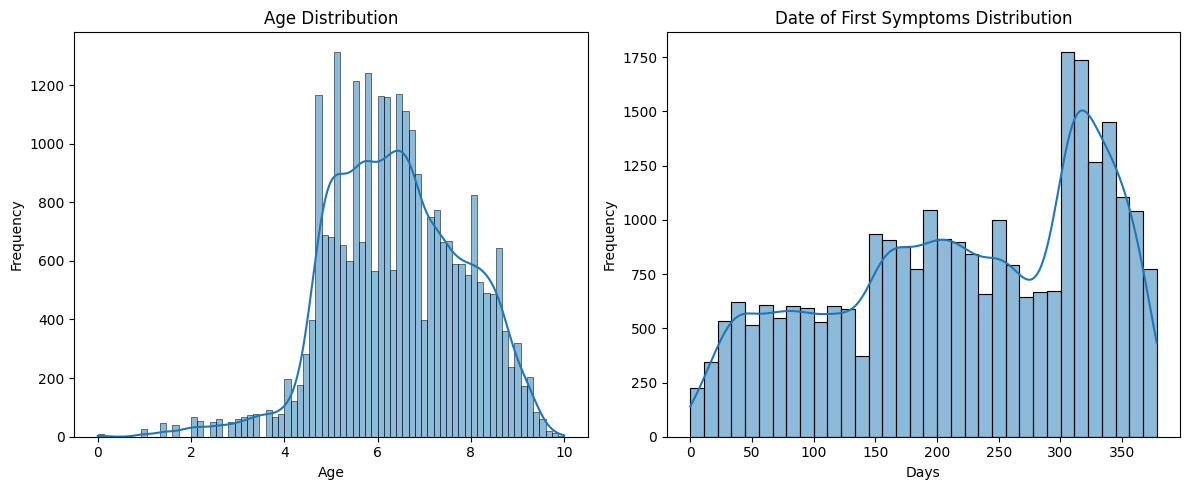

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(np.sqrt(df['age']), kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['date_of_first_symptoms'], kde=True)
plt.title('Date of First Symptoms Distribution')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Age could benefit from a transformation, so we study a box-plot transformation.



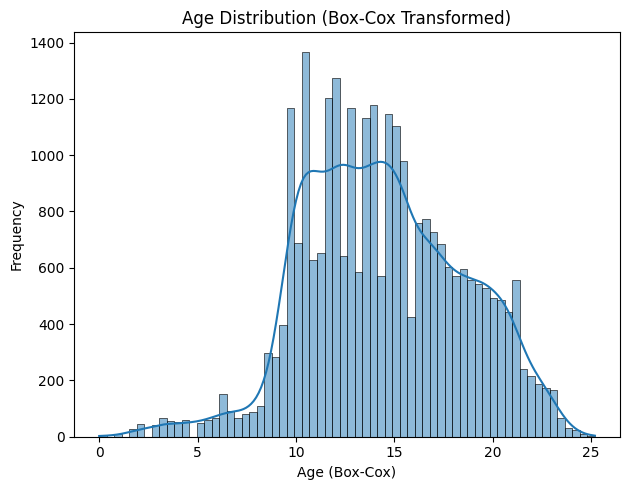

In [ ]:
# Box-Cox transformation to 'age'
df['age_boxcox'], maxlog = boxcox(df['age'] + 2)

# Box-Cox transformation to 'date_of_first_symptoms'
df['date_of_first_symptoms_boxcox'], maxlog = boxcox(df['date_of_first_symptoms'] + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['age_boxcox'], kde=True)
plt.title('Age Distribution (Box-Cox Transformed)')
plt.xlabel('Age (Box-Cox)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Study of the simplicity of the problem

After that we study with a Principal Component Analysis how simple is the problem, by plotting the target values on the first two PC.

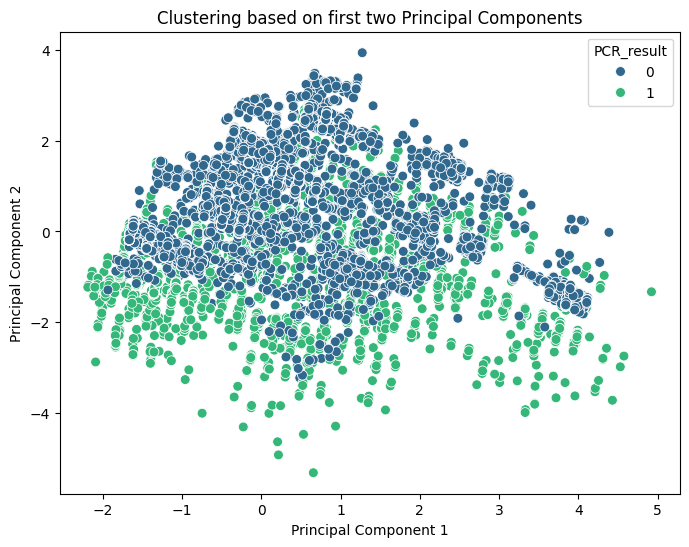

In [ ]:
# Select only numerical features for PCA
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numeric_cols]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['PCR_result'] = final_df['PCR_result']

# Plot the clusters colored by 'PCR_result'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='PCR_result', data=pca_df, palette='viridis', s=50)
plt.title('Clustering based on first two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We see although some observations are easily splitable, most observations need a more complex decision boundary.

# 3. Model Preprocessing

Here the data is loaded back in from the prior cleaned dataset (cleaned.csv) and the data is scaled using StandardScaler and rebalanced, and feature selection is applied (univariate)

### Load Dataset and Apply Scaling
The dataset used for the implementation of the models, is the same as the one obtained before the feature selection in the preprocess. This is done, as some of the transformations done in the preprocess are not used in this section (discretization), and some other as using wrapper are implemented.

In [ ]:
# Had to add shortcut to folder in drive first to recognize shared folder
df = pd.read_csv('/content/drive/MyDrive/Data Processes/cleaned.csv')

df = df.replace(np.nan,None)
df = df[~df.isnull().all(1)]

x = df.iloc[:,:-1]

x_cols = x.columns

# For x select all columns except the last
X = df.iloc[:,1:-1].to_numpy()

# Scale dataset (only numeric features which are the first 3 columns)
scaler = StandardScaler()

scaler.fit(X[:,:3])

XScaled = scaler.transform(X[:,:3])

XScaled = np.concatenate((XScaled,X[:,3:]),axis=1)

# For y select the last column
y_df = df.iloc[:,:-1]
y = df.iloc[:,-1].to_numpy()

# Set aside a copy for predictions
X_real = XScaled
y_real = y

#### Apply Class Rebalancing

In [ ]:
# Check dataset to see if it's imabalanced
df['PCR_result'].value_counts()

from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Rebalance classes using SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(XScaled, y)

y_resampled = y_resampled.reshape(-1,1)

# Export a copy of data with resampled info
col_names = []

for a_col in df.columns[1:]:
    col_names.append(a_col)

print(len(col_names))
print(X_resampled.shape[1])

data_out=pd.DataFrame(np.concatenate((X_resampled,y_resampled),axis=1),columns=col_names)
data_out.to_csv('cleaned_2.csv',index=False)

49
48


### Apply Mutual Information Filter (Univariate Filter) and Create Feature Subsets

In [ ]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

# Select the top 40% of features based on mutual information
selector = SelectPercentile(mutual_info_classif, percentile=40)

X_selected = selector.fit_transform(X_resampled, y_resampled)
X_selected_cols = df.iloc[:,1:-1].columns[selector.get_support()]
print(X_selected_cols)

# Crreate a library of different feature subsets for the models to train on

X_lib = {'All Vars':X_resampled,'univariate':X_selected,'wrapper':X_resampled}

# filter the X variables (for univariate filter) for later predictions
X_real = XScaled[:,selector.get_support()]
y_real = df.iloc[:,-1]

print(X_real)
print(X_real.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Index(['age', 'fever_temperature', 'oxygen_saturation', 'gender',
       'history_of_fever', 'cough', 'sore_throat', 'runny_nose',
       'shortness_of_breath', 'headache', 'fatigue_malaise', 'muscle_aches',
       'joint_pain', 'inability_to_walk', 'abdominal_pain', 'diarrhoea',
       'vomiting_nausea', 'hypertension', 'smoking'],
      dtype='object')
[[ 2.18846400e-01  1.11714679e+00  2.96104579e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.10336114e+00 -4.46606783e-01  2.96104579e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.38085197e-01  8.56521197e-01  1.71401697e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.11705485e-01  7.46444091e-02  5.45510342e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.20464285e-10  4.24899155e-10 -3.39365535e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.20464285e-10  4.24899155e-10 -3.39365535e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
(27449,

### Create a dataframe to save model results

In [ ]:
model_results=pd.DataFrame()

# 4. Model Implementation

Here the logistic regression model and decision tree classifier are considered, and their evaluation metrics are outputted to a csv (model_results)


###Logistic Regression

In [ ]:
#Logistic Regression
model = LogisticRegression()

aucs_ = []
tprs_ = []
fprs_ = []

for a_set in X_lib.keys():
    y = y_resampled.ravel()
    X_vars = X_lib[a_set]
    variables = a_set
    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    if variables == 'wrapper':
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select = 'auto', direction = 'forward')
        selector.fit(X_train, y_train)
        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()
        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]
        X_vars=X_vars[:,selected_indices]
        # print(np.shape(X_vars))

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    # Use gridsearch and iterate through key hyperparameter values
    grid = {"penalty":['l1','l2'],
           'C':[.5,.75,1,1.25,1.5,2,2.5,3,3.5,4,4.5,10],
           'solver':['liblinear']
           }
    model = LogisticRegression()

    gs_cv = GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)

    # Use KFold CV as well using the GridSearch Parameters
    scores = []
    precisions = []
    recalls = []
    f1s = []
    tps = []
    tns = []
    fps = []
    fns = []
    # aucs = []
    tprs = []
    fprs = []
    n_tps = 0
    n_tns = 0
    n_fps = 0

    kFold=KFold(n_splits=5,shuffle=False)

    # Use best gridsearch parameter and iterate across the five folds
    counter = 1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        model = LogisticRegression(penalty = gs_cv.best_params_['penalty'], C = gs_cv.best_params_['C'],
                                  solver = gs_cv.best_params_['solver'] )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        preds = model.predict(X_test)
        C = confusion_matrix(y_test, preds)
        # print(C)

        # Assemble confusion matrix for each cross fold and generate metrics
        tp = C[0,0]
        tn = C[1,1]
        fp = C[1,0]
        fn = C[0,1]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        precision = tp/(tp+fp)
        precisions.append(precision)
        recall = tp/(tp+fn)
        recalls.append(recall)
        f1 = 2*tp/((2*tp)+fp+fn)
        f1s.append(f1)
        counter+=1

    # Generate aggregate metrics of model performance across all data
    kfold_mean_precision = np.mean(precisions)
    kfold_mean_recall = np.mean(recalls)
    kfold_mean_f1 = np.mean(f1s)

    kfold_min_precision = np.min(precisions)
    kfold_min_recall = np.max(recalls)
    kfold_min_f1 = np.min(f1s)

    kfold_max_precision = np.max(precisions)
    kfold_max_recall = np.max(recalls)
    kfold_max_f1 = np.max(f1s)


    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)


    ## Add all results into a dataframe for later analysis
    temp_results=pd.DataFrame({'algorithm':['Logistic Regression'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_max_accuracy],
                               'cv_mean_accuracy':[kfold_mean_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns]
                               })
    model_results=pd.concat([model_results,temp_results])

    ### Print model coefficients
    model_results=pd.concat([model_results,temp_results])
    # if variables=='univariate_filter':
    print(model.coef_, model.intercept_)




variables method: All Vars
Grid Search
Cross Validation
[[ 7.81254397e-02  1.49447411e-02 -5.85839399e-02  9.50532041e-02
  -5.66685088e-01 -4.49871123e-01 -1.39039898e-03 -2.99678738e-01
   3.88452130e-01  1.15267487e+00  3.22329095e-01  3.25373589e-02
   1.66571752e+00  0.00000000e+00 -2.95549928e-02 -1.11287545e-01
  -5.61571359e-01 -5.09371581e-01  3.13738210e-01  1.09014600e-01
  -3.13928636e-03 -3.71811021e-01  0.00000000e+00  1.47212526e-01
  -2.60782421e-01  5.01682618e-01  6.39946479e-01  1.72687121e-01
   3.27108266e-01  5.03454779e-01  9.55444290e-02  7.90232253e-01
   3.55048335e-01  1.99989011e-01  1.22728078e-01  4.03533027e-01
   6.06267989e-01  0.00000000e+00  3.65652115e-01  3.50103470e-01
   0.00000000e+00  7.11962176e-01  1.10084654e+00  5.19357472e-01
   3.58060033e-02  1.34107815e+00  9.74604109e-01 -4.38917219e-02]] [0.94858062]
variables method: univariate
Grid Search
Cross Validation
[[ 0.0796812   0.01445058 -0.05788249  0.09395255 -0.57656144 -0.44198301
   0.

###Decision Tree

In [ ]:
# Decision Tree
model = DecisionTreeClassifier()

# Iterate through each set of feature selection methods
for a_set in X_lib.keys():
    y = y_resampled.ravel()
    X_vars = X_lib[a_set]
    variables = a_set
    print('variables method: '+variables)
    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    # Apply wrapper method conditionally
    if variables == 'wrapper':
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, direction='forward')
        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()
        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]
        X_vars=X_vars[:,selected_indices]
        # print(np.shape(X_vars))

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    # Use gridsearch and iterate through key hyperparameter values
    model = DecisionTreeClassifier()
    grid = {"criterion":['gini', 'entropy', 'log_loss' ],
            'max_features': [1,3,5,10,15,20,25,30],
            'max_depth': [1,3,5,10,15,20,25,30],
            'min_samples_split':[1,3,5,10,15,20,25,30]
            }

    gs_cv = GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)

    # Use KFold CV as well using the GridSearch Parameters
    scores = []
    precisions = []
    recalls = []
    f1s = []
    tps = []
    tns = []
    fps = []
    fns = []
    aucs = []
    fprs = []
    tprs = []

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter and iterate through the five folds

    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))

        model=DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'],
                                     max_features=gs_cv.best_params_['max_features'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     min_samples_split=gs_cv.best_params_['min_samples_split']
                                     )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        preds=model.predict(X_test)
        C=confusion_matrix(y_test, preds)
        # print(C)

        # Assemble confusion matrix for each cross fold and generate metrics
        tp = C[0,0]
        tn = C[1,1]
        fp = C[1,0]
        fn = C[0,1]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        precision = tp/(tp+fp)
        precisions.append(precision)
        recall = tp/(tp+fn)
        recalls.append(recall)
        f1 = 2*tp/((2*tp)+fp+fn)
        f1s.append(f1)
        counter+=1


    # Generate aggregate metrics of model performance across all data
    kfold_mean_precision = np.mean(precisions)
    kfold_mean_recall = np.mean(recalls)
    kfold_mean_f1 = np.mean(f1s)

    kfold_min_precision = np.min(precisions)
    kfold_min_recall = np.max(recalls)
    kfold_min_f1 = np.min(f1s)

    kfold_max_precision = np.max(precisions)
    kfold_max_recall = np.max(recalls)
    kfold_max_f1 = np.max(f1s)

    kfold_mean_tps = np.mean(tps)
    kfold_mean_tns = np.mean(tns)
    kfold_mean_fps = np.mean(fps)
    kfold_mean_fns = np.mean(fns)

    kfold_mean_accuracy = np.mean(scores)
    kfold_min_accuracy = np.min(scores)
    kfold_max_accuracy = np.max(scores)

    # Add all results into a dataframe for later analysis
    temp_results = pd.DataFrame({'algorithm':['Decision Tree'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_max_accuracy],
                               'cv_mean_accuracy':[kfold_mean_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns]
                               })
    model_results = pd.concat([model_results,temp_results])

    # Save a decision tree image of the univariate filter
    if variables == 'univariate':
        model_univariate=model

        print(X_train)
        plt.figure(figsize =(100,100))
        plot_tree(model,feature_names = X_selected_cols,fontsize = 8)
        # plt.savefig('decision_tree.png')

# Create a comparison dataframe of model output vs
predictions=pd.DataFrame(y_real,columns = ['PCR_result'])

# Predict entire dataset to get numbers contextualized with the
predictions['yhat'] = model_univariate.predict(X_real)

# Output model predictions
predictions.to_csv('predictions.csv', index = False)

Output hidden; open in https://colab.research.google.com to view.

### Output

In [ ]:
# Export Model Output Results for Analysis
model_results.to_csv('model_results.csv', index = False)